## SET ENVIRONMENT VARIABLES

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

print(os.environ["CUDA_VISIBLE_DEVICES"])

7


## Import and Prepare the DataSets

### 1. Import Train & Test CSV(s)

In [27]:
import pandas as pd
import json

# Set the TRAIN_SAMPLING_TECHNIQUE as follows
# SMOTE ---> 'sm'
# SMOTETomek ---> 'smt'
# ADASYN ---> 'ada'
TRAIN_SAMPLING_TECHNIQUE = 'sm'

# Set the TEST_SAMPLING_TECHNIQUE as follows
# RandomUnderSampler ---> 'rus'
# TomekLinks ---> 'tmk'
TEST_SAMPLING_TECHNIQUE = 'rus'

# Importing Training Set
train = pd.read_csv(f'./split_ds/opcode_{TRAIN_SAMPLING_TECHNIQUE}_TRAIN.csv')
train['opcode'] = train['opcode'].apply(lambda x: json.loads(x))

# Importing Testing Set
test = pd.read_csv(f'./split_ds/opcode_{TEST_SAMPLING_TECHNIQUE}_TEST.csv')
test['opcode'] = test['opcode'].apply(lambda x: json.loads(x))

print(train, test)

                                                   opcode  swc_label
0       [2, 2, 10, 2, 49, 33, 5, 13, 2, 30, 62, 3, 32,...          0
1       [2, 2, 10, 2, 49, 33, 5, 13, 2, 30, 2, 102, 4,...          0
2       [2, 2, 10, 2, 49, 33, 5, 13, 2, 30, 62, 3, 32,...          0
3       [2, 2, 10, 2, 49, 33, 5, 13, 2, 30, 62, 3, 32,...          0
4       [2, 2, 10, 25, 62, 2, 30, 32, 11, 25, 7, 26, 5...          0
...                                                   ...        ...
279131  [92, 21, 26, 12, 65, 13, 21, 91, 0, 0, 0, 0, 0...          1
279132  [2, 2, 10, 2, 49, 33, 5, 13, 2, 30, 62, 3, 32,...          1
279133  [2, 2, 10, 2, 49, 33, 39, 13, 2, 30, 62, 3, 32...          1
279134  [2, 2, 10, 43, 16, 8, 12, 3, 29, 62, 2, 31, 25...          1
279135  [2, 2, 10, 32, 25, 14, 10, 5, 28, 40, 2, 28, 1...          1

[279136 rows x 2 columns]                                                   opcode  swc_label
0      [2, 2, 10, 2, 49, 33, 5, 13, 2, 30, 62, 3, 32,...          0
1      [2

### 2. Split the Test DataSet into Testing and Validiation DataSet

In [3]:
from sklearn.model_selection import train_test_split
test, val = train_test_split(test, test_size=0.5, random_state=69, shuffle=True, stratify=test['swc_label'])

### 3. Convert DataFrame(s) to Numpy N-D Array(s)

In [4]:
import numpy as np

train_sequences = np.array(train['opcode'].tolist())
train_labels = np.array(train['swc_label'].tolist())

test_sequences = np.array(test['opcode'].tolist())
test_labels = np.array(test['swc_label'].tolist())

val_sequences = np.array(val['opcode'].tolist())
val_labels = np.array(val['swc_label'].tolist())

print("Train-Sequences", train_sequences.shape, type(train_sequences[0]))
print("Train-Labels", train_labels.shape, type(train_labels[0]))
 
print("Test-Sequences", test_sequences.shape, type(test_sequences[0]))
print("Test-Labels", test_labels.shape, type(test_labels[0]))
 
print("Validiation-Sequences", val_sequences.shape, type(val_sequences[0]))
print("Validiation-Labels", val_labels.shape, type(val_labels[0]))

Train-Sequences (279136, 1800) <class 'numpy.ndarray'>
Train-Labels (279136,) <class 'numpy.int64'>
Test-Sequences (16335, 1800) <class 'numpy.ndarray'>
Test-Labels (16335,) <class 'numpy.int64'>
Validiation-Sequences (16335, 1800) <class 'numpy.ndarray'>
Validiation-Labels (16335,) <class 'numpy.int64'>


## Create & Evaluate the Deep-Learning Model (RNN based on LSTM architecture)

### 1. Define the Hyper-Parameters

In [12]:
OPCODE_SEQ_LEN = 1800
EMBEDDING_DIM = 50
NUM_EPOCS = 128
BATCH_SIZE = 128

### 1A. Import Evaluation metrics

In [13]:
from sklearn.metrics import f1_score

def f1(y_true, y_pred):
    return f1_score(y_true, y_pred)

def f1M(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

### 2. Define the Neural Network Structure (Layers)

In [14]:
import tensorflow as tf

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Embedding(150, EMBEDDING_DIM, input_length=OPCODE_SEQ_LEN))
model.add(tf.keras.layers.LSTM(128, name='lstm1', return_sequences=True))
model.add(tf.keras.layers.LSTM(64, name='lstm2'))
model.add(tf.keras.layers.Dense(256, name='hi_layer', activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, name='out_layer', activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1800, 50)          7500      
_________________________________________________________________
lstm1 (LSTM)                 (None, 1800, 128)         91648     
_________________________________________________________________
lstm2 (LSTM)                 (None, 64)                49408     
_________________________________________________________________
hi_layer (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
Total params: 165,453
Trainable params: 165,453
Non-trainable params: 0
________________________________________________

### 3. Compile the model

In [15]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### 4. Fit and train the RNN model with Training and Validiation Data

In [ ]:
history = model.fit(train_sequences, train_labels, 
 epochs=NUM_EPOCS, 
 validation_data=(val_sequences, val_labels),
 batch_size=BATCH_SIZE, verbose=1)

Epoch 1/128
2181/2181 [==============================] - 459s 210ms/step - loss: 0.4710 - accuracy: 0.7579 - val_loss: 0.2814 - val_accuracy: 0.8808
Epoch 2/128
2181/2181 [==============================] - 458s 210ms/step - loss: 0.1410 - accuracy: 0.9430 - val_loss: 0.2064 - val_accuracy: 0.9079
Epoch 3/128
2181/2181 [==============================] - 461s 211ms/step - loss: 0.0869 - accuracy: 0.9617 - val_loss: 0.1374 - val_accuracy: 0.9347
Epoch 4/128
2181/2181 [==============================] - 477s 219ms/step - loss: 0.0716 - accuracy: 0.9677 - val_loss: 0.1120 - val_accuracy: 0.9467
Epoch 5/128
2181/2181 [==============================] - 540s 248ms/step - loss: 0.0613 - accuracy: 0.9731 - val_loss: 0.1167 - val_accuracy: 0.9449
Epoch 6/128
2181/2181 [==============================] - 524s 240ms/step - loss: 0.0539 - accuracy: 0.9764 - val_loss: 0.1063 - val_accuracy: 0.9478
Epoch 7/128
2181/2181 [==============================] - 543s 249ms/step - loss: 0.0497 - accuracy: 0.9782

### 5. Evaluate performance of model using Testing DataSet

In [25]:
results = model.evaluate(test_sequences, test_labels, batch_size=BATCH_SIZE)
print("Test Loss, Test Accuracy:", results)

128/128 [==============================] - 9s 72ms/step - loss: 0.1836 - accuracy: 0.9788
Test Loss, Test Accuracy: [0.18357998132705688, 0.9788184762001038]


### 6. Save the model as HDF5 file

In [28]:
model.save(f'./models/model_{TRAIN_SAMPLING_TECHNIQUE}_{TEST_SAMPLING_TECHNIQUE}_{NUM_EPOCS}.h5') 

In [29]:
# Save History as Pickle
import pickle
with open(f'./models/history_{TRAIN_SAMPLING_TECHNIQUE}_{TEST_SAMPLING_TECHNIQUE}_{NUM_EPOCS}.pickle', 'wb') as fh:
 pickle.dump(history.history, fh)

# Save Results as Pickle
import pickle
with open(f'./models/results_{TRAIN_SAMPLING_TECHNIQUE}_{TEST_SAMPLING_TECHNIQUE}_{NUM_EPOCS}.pickle', 'wb') as fh:
 pickle.dump(results, fh)

### 7. Plot performance metrics of the Deep-Learning Model 

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

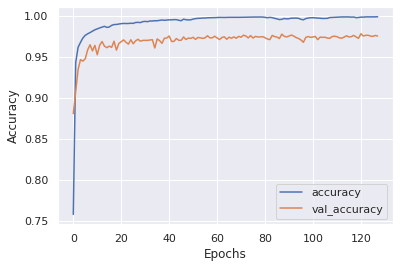

In [21]:
# Accuracy Metrics
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

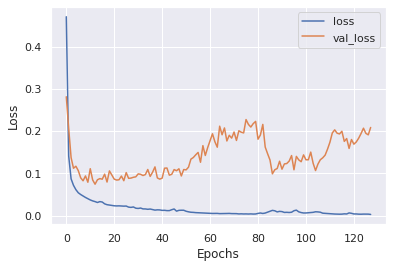

In [22]:
# Loss Metrics
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [24]:
pred_test_classes = model.predict_classes(test_sequences, verbose=1, batch_size=128)
pred_train_classes = model.predict_classes(train_sequences, verbose=1, batch_size=128)

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

print('Train Metrics\n-------------------------')
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(train_labels, pred_train_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(train_labels, pred_train_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(train_labels, pred_train_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(train_labels, pred_train_classes)
print('F1 score: %f' % f1)
f1M = f1_score(train_labels, pred_train_classes, average='macro')
print('F1-Macro score: %f' % f1M)
# confusion matrix
matrix = confusion_matrix(train_labels, pred_train_classes)
print(matrix)

print('Test Metrics\n-------------------------')
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_labels, pred_test_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_labels, pred_test_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_labels, pred_test_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_labels, pred_test_classes)
print('F1 score: %f' % f1)
f1M = f1_score(test_labels, pred_test_classes, average='macro')
print('F1-Macro score: %f' % f1M)
# confusion matrix
matrix = confusion_matrix(test_labels, pred_test_classes)
print(matrix)

2181/2181 [==============================] - 159s 73ms/step
Train Metrics
-------------------------
Accuracy: 0.999316
Precision: 0.999155
Recall: 0.999477
F1 score: 0.999316
F1-Macro score: 0.999316
[[139450    118]
 [    73 139495]]
Test Metrics
-------------------------
Accuracy: 0.978818
Precision: 0.990838
Recall: 0.966577
F1 score: 0.978557
F1-Macro score: 0.978815
[[8094   73]
 [ 273 7895]]
